# Final Project

The final project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be *self-contained*, so it can be executed if necessary.

The submission includes two parts:
1. this notebook
2. a 15-min presentation, to be held on May 8


## Submission
The project is due on ***May 07, 23:59 CET*** (counted as the time stamp when it is received). Late submissions will **not** be considered, and graded as 0! 

To submit, please:

1. copy this file and all additional data into a folder with your group ID
3. zip the folder
4. send a copy of the zip file to Dirk Hovy <dirk.hovy@unibocconi.it> and Tommaso Fornaciari <fornaciari@unibocconi.it>

## 1. Data, Preprocessing, and Annotation (4 pts)

Find a data set for text classification and a data set for structured prediction. These can be the same.
Kaggle is a good place to start, or the Google data set search. 

The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. If there is no label provided, you can annotate your own. You can get up to **3 bonus points** for annotation, depending on the amount and complexity of the annotation.

Split the data into dedicated training, development, and test sets (if they do not include these already)!

Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at. 

...

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.


In [46]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from gensim.models import Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn

from collections import Counter

from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from gensim.sklearn_api import D2VTransformer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import InputLayer
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM, Flatten
from keras.layers import Dropout, Dense, Activation

In [334]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [356]:
nlp = spacy.load('en_core_web_sm')

def preprocessing(sentence, entity_rec = False, POS_tagging_prep = True):
    """
    Input: A document
    Output: A cleaned, tokenised document
    """
    s_list = []
    # POS_tagging and preprocessing 
    if POS_tagging_prep == True:
         return ' '.join([token.lemma_ for token in nlp(sentence) if (token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'} and (token.lemma_.lower() != '’s') 
                                                                  and (token.is_stop == False) and (token.is_punct == False) 
                                                                  and (token.like_url == False))])
                
    # Tokenisation / stop-word removal / punctuation removal / url removal
    else:
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
        if entity_rec == True:
            s_analysed = nlp(sentence)
            # Entity recognition
            entity = [entity.text for entity in s_analysed.ents]
            for words in entity:
                modified_words = words.replace(" ", "_")
                sentence = sentence.replace(words, modified_words)        
        s_analysed = nlp(sentence.replace("’s", "")) # removal of ’s before tokenisation 
        for token in s_analysed:
            if (token.is_stop == False) and (token.is_punct == False) and (token.like_url == False):
                s_list.append(token.lemma_.lower())
    return s_list

def verb(text):
    '''
    return the strings with the verbs only
    '''
    return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if token.pos_ in {'VERB'}])

In [69]:
#data['cleaned'] = data.headline.apply(preprocessing, entity_rec = True)
#data['verb'] = data.headline.apply(verb)

There are 28619 article headlines
Presence of NAN True
0    14985
1    13634
Name: is_sarcastic, dtype: int64


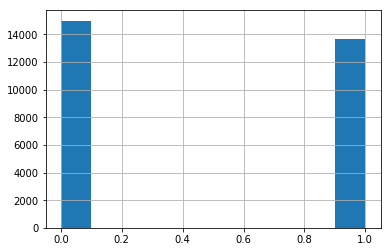

In [51]:
# data.drop("article_link", axis = 1, inplace = True)

data['Set'] = np.random.choice(
    ['train', 'valid', 'test'],
    data.shape[0],
    p=[0.7, 0.15, 0.15]
)

print("There are", data.shape[0],'article headlines')
print("Presence of NAN" , data.isna().values.any())
print(data.is_sarcastic.value_counts())
data.is_sarcastic.hist()

#### **The target is pretty balanced so looking at accuracy makes total sense**

In [71]:
#data.to_csv('cleaned_data.csv')

In [2]:
data = pd.read_csv("cleaned_data.csv")
data.cleaned.dropna(axis = 0,inplace= True)

In [3]:
no_verb = data[["headline","cleaned","Set","is_sarcastic"]].dropna()

In [4]:
data.head()

,Unnamed: 0,headline,is_sarcastic,cleaned,verb,Set
0,0,thirtysomething scientists unveil doomsday clo...,1,thirtysomething scientist hair loss,NaN,train
1,1,dem rep. totally nails why congress is falling...,0,totally nail fall short gender racial equality,nail fall,train
2,2,eat your veggies: 9 deliciously different recipes,0,eat veggie deliciously different recipe,eat,train
3,3,inclement weather prevents liar from getting t...,1,inclement weather prevent liar get work,prevent get work,train
4,4,mother comes pretty close to using word 'strea...,1,mother come pretty close word streaming correctly,come use,test


In [5]:
no_verb.cleaned.isna().any()

False

In [6]:
sarcasm = no_verb.loc[no_verb["is_sarcastic"] == 1,["headline","cleaned","verb"]]
normal = no_verb.loc[no_verb["is_sarcastic"] == 0,["headline","cleaned","verb"]]

/home/hugopao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [43]:
X_train = no_verb.loc[no_verb.Set =='train', ["cleaned"]]
y_train = no_verb.loc[no_verb.Set =='train', ["is_sarcastic"]]

X_valid = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_valid = no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

X_test = no_verb.loc[no_verb.Set =='test', ["cleaned"]]
y_test = no_verb.loc[no_verb.Set =='test', ["is_sarcastic"]]

## 2. Research Question(s) (2 pts)

Describe what question you are investigating with the data (max. 100 words)

## **Report: Amazon Using Heat-Sensing Alien Hunters To Track Workers Attempting To Unionize**

#### **Now, is this a sarcastic headline or not? We are interested in developing an algorithm that is able to detect sarcasm. While this remains an active research area and is considered one of the toughest challenges in NL (https://link.springer.com/article/10.1007/s10462-019-09791-8?shared-article-renderer), we are confident in tackling this issue by examining the underlying topics, document embeddings and developing a language model. On this basis, we develop a prediction machine.**

## 3. Analysis (6 pts)

Apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Topic modeling with LDA (3 pts). Justify your choice of number of topics!
2. Dense word embeddings ***or*** document embeddings: visualize these and show a clustering (3 pts) 

Your analysis needs to be run on the training data only! You can use the dev set for tuning.

### Other methods
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

In [10]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, #df stands for document frequency
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Sarcasm Words")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.tail()

Sarcasm Words


,word,tf,idf,tfidf
18,nation,385,4.569496,308.890973
37,woman,466,4.388481,360.380507
24,report,573,4.166645,455.597051
19,new,753,3.905490,615.215899
17,man,1001,3.612780,743.379542


In [11]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(normal.cleaned.dropna().tolist()) #I use the title to get the topic
vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(normal.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Normal")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.tail()

Normal


,word,tf,idf,tfidf
14,man,314,4.860292,256.871140
21,say,395,4.630145,344.223808
31,woman,473,4.473098,389.389017
16,new,477,4.447400,400.367527
25,trump,498,4.397906,432.726904


# **Language Model**

In [12]:
from collections import defaultdict
import numpy as np
import nltk


smoothing = 0.001
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
sarcasm["headline"] = sarcasm["headline"].astype(str)
corpus = [line.strip().split() for line in sarcasm.headline.tolist()]

#collect and count
for sentence in corpus:
    #include start and stop in the sentence
    tokens = ['*', '*','*','*','*'] + sentence + ['STOP']
    for u, v, w, x, y, z in nltk.ngrams(tokens, 6): #we create the ngrams from the sentence and we count them
        counts[u, v, w, x, y][z] += 1

def logP(u, v, w):
    #(u,v,w) => P(w) preceeded by u,v we compute the log proba. to avoid numbers that are too small to divivde byand get infinty
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    #score a sentence in log likelihood with chain rule (product becomes sum with log) S: lits of strings
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])
    #for each sentence we eaxtract the trigrams and we compute their proba, and then sum it so we get the log likelihood

In [13]:
def sample_next_word(u, v, w, x, y):
    #sample a word v based on the history (u,v)
    keys, values = zip(*counts[(u, v, w, x, y)].items()) #items returns a litsof tuples keys and values
    #zip takes any number of arguments and zips them together 
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position (returns a position)
    return keys[np.argmax(sample)]

def generate2(initial=[]):
    result = ['*', '*','*','*','*'] + initial
    next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])
    return result

In [14]:
print(generate2(['john']))

* * * john bolton insists iran likely harboring dangerous terrorist osama bin laden


In [15]:
print(generate2(['john']))

* * * john edwards pays $30 to register edwards2016.com just in case


In [16]:
print(generate2(['john']))

* * * john kelly resigns in last-ditch effort to save his and trump's friendship


In [17]:
print(generate2(['politicians']))

* * * politicians ignoring the dangers of jowl implants


In [27]:
print(generate2([]))

* * * universe feels zero connection to guy tripping on mushrooms


In [48]:
#checking if the generated headlines is in the training data
print(sarcasm["headline"].str.contains("universe feels zero connection to guy tripping on mushrooms").any())
print(sarcasm["headline"].str.contains("politicians ignoring the dangers of jowl implants").any())
print(sarcasm["headline"].str.contains("john bolton insists iran likely harboring dangerous terrorist osama bin laden").any())
print(sarcasm["headline"].str.contains("john edwards pays $30 to register edwards2016.com just in case").any())

True
True
True
False


### Trying with 2grams because with 6grams its too specific and the language model just spits out headlines from the training data

In [31]:
from collections import defaultdict
import numpy as np
import nltk



for sentence in corpus:
    tokens = ['*', '*'] + sentence + ['STOP']
    for u, v, w in nltk.ngrams(tokens, 3):
        counts[(u, v)][w] += 1

def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

In [32]:
def sample_next_word(u, v):
    keys, values = zip(*counts[(u, v)].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position
    return keys[np.argmax(sample)]

def generate():
    result = ['*', '*']
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])

In [34]:
generate()

"dog can't believe he left consulate"

In [38]:
generate()

'deceased souls backed up at tall building thinking about, you know'

In [56]:
generate()

'sighing trump sexual assault has cooled down'

In [50]:
generate()

'increasingly desperate advertisers settle for more attainable 35-to-44-year-old demographic'

In [54]:
generate()

'matt lauer returns to stage for humans'

In [57]:
print(sarcasm["headline"].str.contains("dog can't believe he left consulate").any())
print(sarcasm["headline"].str.contains("deceased souls backed up at tall building thinking about, you know").any())
print(sarcasm["headline"].str.contains("sighing trump sexual assault has cooled down").any())
print(sarcasm["headline"].str.contains("matt lauer returns to stage for humans").any())

False
False
False
False


# **LDA topic model**

In [75]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing





# get dictionary
instances = sarcasm.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(74 unique tokens: ['get', 'work', 'come', 'run', 'area']...)


In [76]:
instances[:5]

0             [thirtysomething, scientist, hair, loss]
3       [inclement, weather, prevent, liar, get, work]
4    [mother, come, pretty, close, word, streaming,...
7    [warm, donation, nearly, cost, fail, balloon, ...
8         [shadow, government, get, large, meet, room]
Name: cleaned, dtype: object

In [77]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [78]:
num_topics = 11

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

679.75
fitting model
done in 3.3294999599456787


In [79]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("Sarcasm Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

Sarcasm Topics
1 "friend", "call", "kill", "reveal", "ask"
2 "nation", "man", "come", "find", "take"
3 "man", "think", "area", "run", "new"
4 "look", "man", "people", "little", "life"
5 "get", "give", "spend", "trump", "try"
6 "new", "year", "thing", "guy", "local"
7 "go", "family", "death", "school", "want"
8 "know", "way", "watch", "time", "mom"
9 "introduce", "plan", "man", "report", "feel"
10 "old", "woman", "study", "world", "couple"
11 "day", "self", "child", "report", "announce"


## Non sarcasm LDA

In [81]:
# get dictionary
normal['verb'] = normal.cleaned.apply(str)
# run on 50000 instances
instances = normal.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(85 unique tokens: ['way', 'know', 'parent', 'tell', 'leave']...)


In [82]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [83]:
num_topics = 11

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

743.0
fitting model
done in 4.317033290863037


In [84]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("NOrmal headlines Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

NOrmal headlines Topics
1 "right", "make", "war", "take", "think"
2 "year", "thing", "day", "bad", "real"
3 "good", "watch", "school", "fire", "let"
4 "trump", "say", "plan", "know", "fight"
5 "people", "talk", "tell", "want", "climate"
6 "new", "attack", "go", "care", "health"
7 "get", "photo", "campaign", "leave", "time"
8 "video", "death", "live", "student", "family"
9 "old", "gun", "police", "work", "star"
10 "woman", "man", "help", "american", "week"
11 "win", "come", "election", "world", "find"


### **Result : sarcasm doesn't differentiate itself by the topic**

## Document embedding

In [341]:
d2v_model = D2VTransformer(size=100, min_count=1, workers=6)
d2v_data = d2v_model.fit_transform(data.cleaned.apply(str.split).tolist())

In [343]:
tsne_d2v = TSNE(n_components=2, verbose = 1, random_state = 42).fit_transform(d2v_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28455 samples in 0.281s...
[t-SNE] Computed neighbors for 28455 samples in 72.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28455
[t-SNE] Computed conditional probabilities for sample 2000 / 28455
[t-SNE] Computed conditional probabilities for sample 3000 / 28455
[t-SNE] Computed conditional probabilities for sample 4000 / 28455
[t-SNE] Computed conditional probabilities for sample 5000 / 28455
[t-SNE] Computed conditional probabilities for sample 6000 / 28455
[t-SNE] Computed conditional probabilities for sample 7000 / 28455
[t-SNE] Computed conditional probabilities for sample 8000 / 28455
[t-SNE] Computed conditional probabilities for sample 9000 / 28455
[t-SNE] Computed conditional probabilities for sample 10000 / 28455
[t-SNE] Computed conditional probabilities for sample 11000 / 28455
[t-SNE] Computed conditional probabilities for sample 12000 / 28455
[t-SNE] Computed conditional probabilities for sa

In [353]:
tfidf = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.75, 
                             stop_words='english')
vector_sample  = tfidf.fit_transform(data.cleaned.tolist())
svd = TruncatedSVD(n_components=2)
low_dim_svd = TruncatedSVD(n_components=2)
low_dim_U = low_dim_svd.fit_transform(vector_sample)

svd_data = pd.DataFrame(low_dim_U, columns = ['x','y'])
svd_data['label'] = data.is_sarcastic

Text(0.5, 1.0, 'T-SNE Decomposition')

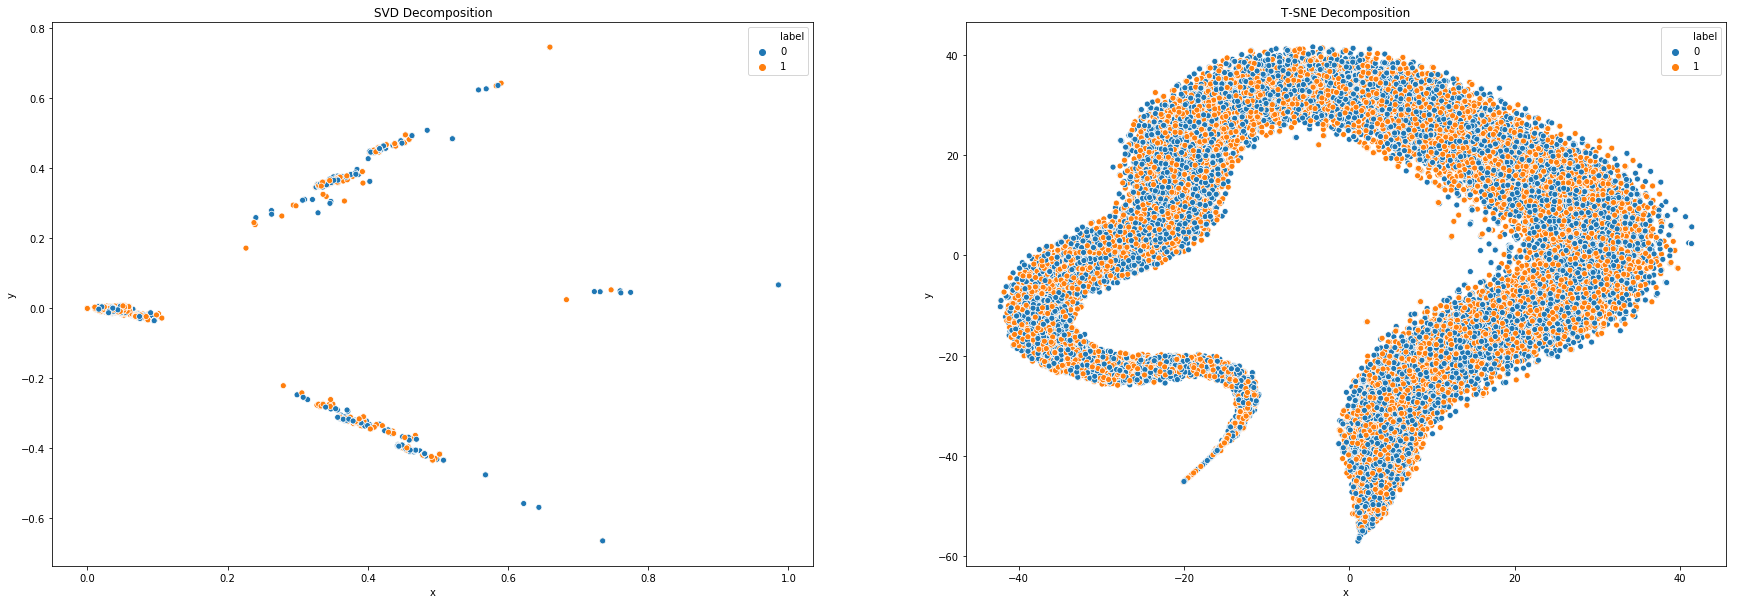

In [354]:
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
tsne_d2v_df['label'] = data.is_sarcastic

plt.figure(figsize = (30, 10))
ax = plt.subplot(1,2,1)
seaborn.scatterplot('x', 'y', data=svd_data, hue='label', ax=ax)
ax.set_title('SVD Decomposition')
ax = plt.subplot(1,2,2)
seaborn.scatterplot('x', 'y', data=tsne_d2v_df, hue='label',ax=ax)
ax.set_title('T-SNE Decomposition')

### This looks really cool, and it shows that it's hard to differentiate between the two groups

## 4. Prediction (15 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. the performance of **at least** two more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

### 4.1 Structured Prediction (6pts)
Run the Structured Prediction model as-is on your sequence prediction task, and note the performance as baseline (1 pt).
Change the features to improve performance (2 pts).
Run a suitable neural net implementation (in `keras`) on the data and compare the best performance to the other two models (4 pts).

In [218]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier



X_dev = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_dev =no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
dumb_predictions = most_frequent.predict(X_dev)

print(classification_report(y_dev, dumb_predictions))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2241
           1       0.00      0.00      0.00      2075

    accuracy                           0.52      4316
   macro avg       0.26      0.50      0.34      4316
weighted avg       0.27      0.52      0.35      4316



/home/hugopao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [219]:
X_train.head()

,cleaned
0,thirtysomething scientist hair loss
1,totally nail fall short gender racial equality
2,eat veggie deliciously different recipe
3,inclement weather prevent liar get work
5,white inheritance


In [220]:
X_train.shape

(19803, 1)

In [30]:
X_valid.head()

,cleaned
10,lesbian consider father amazing
26,new era grow divide
27,thing learn month have baby
35,sculpt cheese strangely alluring
41,florist turn away gay couple want hear case


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.01, 
                             max_df=0.7, 
                             analyzer='word')

X_train = vectorizer.fit_transform(X_train.cleaned.tolist())
print(X_train.shape)

X_valid = vectorizer.transform(X_valid.cleaned.tolist())
X_test = vectorizer.transform(X_test.cleaned.tolist())

(19803, 38)


In [223]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')
%time classifier.fit(X_train, y_train)
print(classifier)

/home/hugopao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 53.6 ms, sys: 105 ms, total: 159 ms
Wall time: 408 ms
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [224]:
X_dev = vectorizer.transform(X_dev.cleaned.tolist())
predictions = classifier.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.58      0.85      0.69      2241
           1       0.67      0.32      0.43      2075

    accuracy                           0.60      4316
   macro avg       0.62      0.59      0.56      4316
weighted avg       0.62      0.60      0.57      4316



In [225]:
classifier_balanced = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                         class_weight='balanced')
%time classifier_balanced.fit(X_train, y_train)
predictions_balanced = classifier_balanced.predict(X_dev)


print(classification_report(y_dev, predictions_balanced))

predictions_balanced_test = classifier_balanced.predict(X_dev)
print(classification_report(y_dev, predictions_balanced_test))

/home/hugopao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 9.77 ms, sys: 4.1 ms, total: 13.9 ms
Wall time: 213 ms
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      2241
           1       0.65      0.35      0.45      2075

    accuracy                           0.60      4316
   macro avg       0.62      0.59      0.57      4316
weighted avg       0.62      0.60      0.57      4316

              precision    recall  f1-score   support

           0       0.58      0.83      0.68      2241
           1       0.65      0.35      0.45      2075

    accuracy                           0.60      4316
   macro avg       0.62      0.59      0.57      4316
weighted avg       0.62      0.60      0.57      4316



In [226]:
import xgboost
clf = xgboost.XGBClassifier(n_estimators = 1000)
clf.fit(X_train, y_train)
predictions_boost = clf.predict(X_dev)
print(classification_report(y_dev, predictions_boost))

/home/hugopao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hugopao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.57      0.86      0.69      2241
           1       0.67      0.30      0.42      2075

    accuracy                           0.59      4316
   macro avg       0.62      0.58      0.55      4316
weighted avg       0.62      0.59      0.56      4316



In [38]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

model = Sequential()
model.add(Dense(128, input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_valid, y_valid))

Train on 19803 samples, validate on 4316 samples
Epoch 1/5
19803/19803 [==============================] - 2s 86us/step - loss: 0.6657 - accuracy: 0.5916 - val_loss: 0.6593 - val_accuracy: 0.5920
Epoch 2/5
19803/19803 [==============================] - 2s 77us/step - loss: 0.6601 - accuracy: 0.5984 - val_loss: 0.6608 - val_accuracy: 0.5989
Epoch 3/5
19803/19803 [==============================] - 2s 76us/step - loss: 0.6593 - accuracy: 0.5995 - val_loss: 0.6564 - val_accuracy: 0.5982
Epoch 4/5
19803/19803 [==============================] - 1s 75us/step - loss: 0.6579 - accuracy: 0.5994 - val_loss: 0.6555 - val_accuracy: 0.6001
Epoch 5/5
19803/19803 [==============================] - 2s 77us/step - loss: 0.6569 - accuracy: 0.6013 - val_loss: 0.6619 - val_accuracy: 0.5966


In [51]:
predictions_deep = (model.predict(X_test)>0.5)
print(classification_report(y_test, predictions_deep))

              precision    recall  f1-score   support

           0       0.57      0.85      0.68      2239
           1       0.66      0.31      0.42      2097

    accuracy                           0.59      4336
   macro avg       0.61      0.58      0.55      4336
weighted avg       0.61      0.59      0.56      4336



In [52]:
X_train = no_verb.loc[no_verb.Set =='train', ["cleaned"]]
y_train = no_verb.loc[no_verb.Set =='train', ["is_sarcastic"]]

X_valid = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_valid = no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

X_test = no_verb.loc[no_verb.Set =='test', ["cleaned"]]
y_test = no_verb.loc[no_verb.Set =='test', ["is_sarcastic"]]

# **BI LSTM model**

In [53]:
# collect known word tokens and tags
wordset = set()
train_instances = [words for words in X_train.cleaned.apply(str.split)]
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        result.append(word_ints)
    return result 

In [54]:
# get some test data
test_instances = [words for words in X_test.cleaned.apply(str.split)]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

In [55]:
# get some valid data
valid_instances = [words for words in X_valid.cleaned.apply(str.split)]

# apply integer mapping
valid_instance_int = convert2ints(valid_instances)


In [56]:
MAX_LENGTH = int(np.percentile([len(instance) for instance in train_instances_int],95))
MAX_LENGTH

9

In [57]:
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_instances_int, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_instances_int, maxlen=MAX_LENGTH, padding='post')
valid_sentences = pad_sequences(valid_instance_int, maxlen=MAX_LENGTH, padding='post')
print(train_sentences[0])

[11302  9764  5030  6505     0     0     0     0     0]


## Model

In [58]:
np.random.seed(42)

model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(64, return_sequences=False), name='bi-LSTM'))
model_seq.add(Dense(256, name = 'fully_connected1', activation = 'relu'))
model_seq.add(Dropout(0.2, name='dropout'))
model_seq.add(Dense(1, activation = 'sigmoid', name='output'))
model_seq.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 9, 128)            1620352   
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 128)               98816     
_________________________________________________________________
fully_connected1 (Dense)     (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 1,752,449
Trainable params: 1,752,449
Non-trainable params: 0
_________________________________________________________________


In [59]:
batch_size = 32
epochs = 5

# compile the model we have defined above
model_seq.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model_seq.fit(train_sentences, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (valid_sentences, y_valid))

/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19803 samples, validate on 4316 samples
Epoch 1/5
19803/19803 [==============================] - 14s 705us/step - loss: 0.5369 - accuracy: 0.7251 - val_loss: 0.4785 - val_accuracy: 0.7627
Epoch 2/5
19803/19803 [==============================] - 14s 688us/step - loss: 0.3317 - accuracy: 0.8559 - val_loss: 0.5482 - val_accuracy: 0.7546
Epoch 3/5
19803/19803 [==============================] - 13s 663us/step - loss: 0.2020 - accuracy: 0.9175 - val_loss: 0.6554 - val_accuracy: 0.7426
Epoch 4/5
19803/19803 [==============================] - 13s 676us/step - loss: 0.1257 - accuracy: 0.9491 - val_loss: 0.8743 - val_accuracy: 0.7347
Epoch 5/5
19803/19803 [==============================] - 14s 683us/step - loss: 0.0797 - accuracy: 0.9663 - val_loss: 1.2063 - val_accuracy: 0.7315


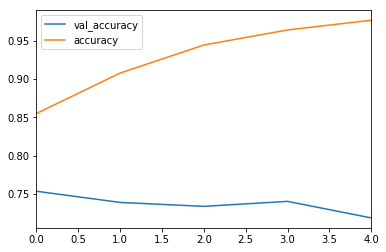

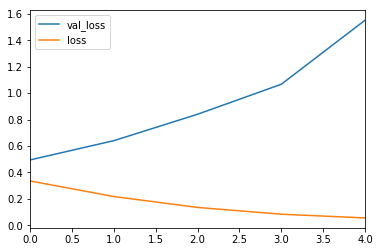

In [417]:
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line()

In [332]:
loss, accuracy = model_seq.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

#this was achieved with one epoch

4336/4336 [==============================] - 0s 44us/step
Test loss: 0.48067975704080507
Test accuracy: 0.7693727016448975


In [74]:
predictions_LSTM = (model_seq.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_LSTM))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      2239
           1       0.73      0.73      0.73      2097

    accuracy                           0.74      4336
   macro avg       0.74      0.74      0.74      4336
weighted avg       0.74      0.74      0.74      4336



In [67]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 128
nb_filter = 64
filter_length = 3
hidden_dims = 128


inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=1)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 9)                 0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 9, 128)            1620352   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 9, 64)             24640     
_________________________________________________________________
activation_8 (Activation)    (None, 9, 64)             0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080

In [24]:
loss, accuracy = model.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4336/4336 [==============================] - 0s 9us/step
Test loss: 0.50219733479718
Test accuracy: 0.7562269568443298


In [76]:
predictions_CNN = (model.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_CNN))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2239
           1       0.72      0.72      0.72      2097

    accuracy                           0.73      4336
   macro avg       0.73      0.73      0.73      4336
weighted avg       0.73      0.73      0.73      4336



## Significance Testing

In [69]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [79]:
p_value, deltas = bootstrap_sample(predictions_CNN, predictions_LSTM, y_test)
print(p_value, p_value < 0.01)

0.148 False


### Performances are not statistically different

## 3. Visualizations (3 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

In [357]:
# your code here
def pos(text):
    return ' '.join([token.pos_ for token in nlp(text)])

# Add new column with parts of speech of each review
data['review_pos'] = data.cleaned.apply(pos)

In [360]:
pos_sarcasm = data.loc[data.is_sarcastic == 1, ["review_pos"]]
pos_normal = data.loc[data.is_sarcastic == 0, ["review_pos"]]

In [383]:
pos_sarcasm = pos_sarcasm.astype(str)
pos_normal = pos_normal.astype(str)

In [384]:
# Here I want to find out whether we can see a difference in the relative amount of nouns, verbs, adjectives, etc. used, 
# i.e. analysing their relative frequency, in positive and negative reviews. 

# Reset the indices of the distinct positive and negative review dataframes
pos_sarcasm.reset_index(drop=True, inplace = True)
pos_normal.reset_index(drop=True, inplace = True)

# POSITIVE - make list of dictionaries for fraction of times the type of word appears in review
dict_list = []
for i in range(pos_sarcasm.shape[0]):
    temp_list = pos_sarcasm.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)

# Make lists for how often each word type appears across the different reviews
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_pos = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_pos[word_type].append(dict_list[i][word_type])


# NEGATIVE - make list of dictionaries for fraction of times the type of word appears in review
dict_list = []
for i in range(pos_normal.shape[0]):
    temp_list = pos_normal.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)
    
# Make lists for how often each word type appears across the different reviews
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_neg = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_neg[word_type].append(dict_list[i][word_type])

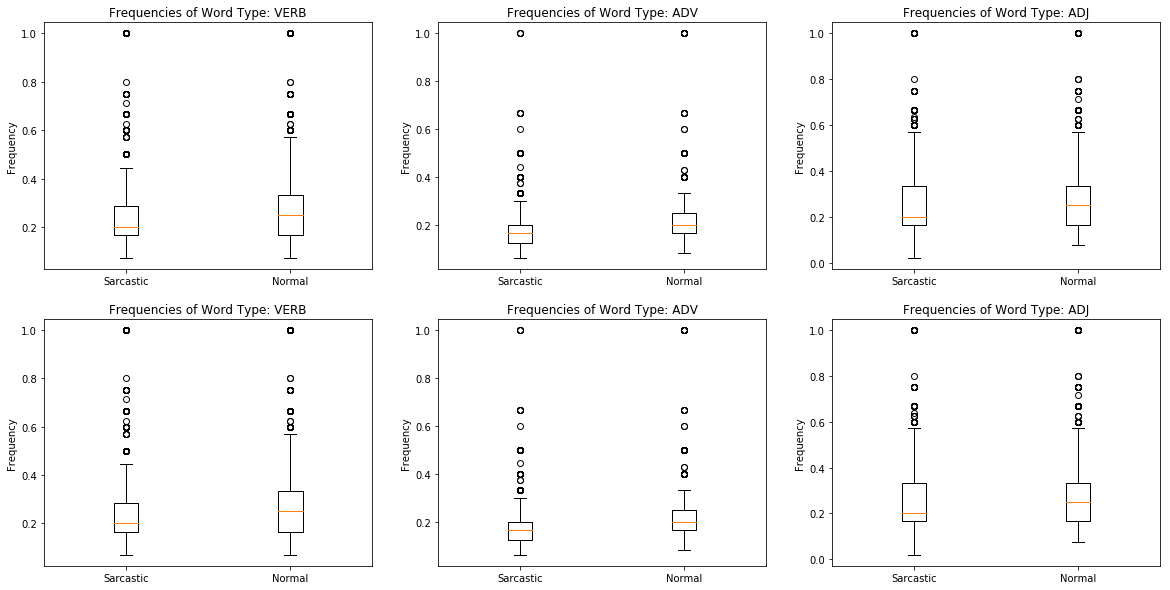

In [415]:
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)
for i, word in zip([0,1,2],relevant_word_types):
    for j in range(2):
        axs[j][i].boxplot([word_type_frequencies_pos[word], word_type_frequencies_neg[word]])
        axs[j][i].set_title('Frequencies of Word Type: %s' %word)
        axs[j][i].set_ylabel('Frequency')
        axs[j][i].set_xticklabels(['Sarcastic', 'Normal'])